### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , LSTM , Embedding
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import pickle

In [2]:
data = pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
data.shape

(568454, 10)

In [4]:
# Check null values
data.isna().sum().to_frame(name='# of missing values')

,# of missing values
Id,0
ProductId,0
UserId,0
ProfileName,16
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


### Remove rows which are having null values

In [5]:
total_rows =  data.shape[0]
data.dropna(how='any',inplace=True)
remaining_rows= data.shape[0]

removed_rows = total_rows-remaining_rows
print("No. of rows removed :", removed_rows)

print(f"\nPercentage of data removed:{np.round((removed_rows/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((remaining_rows/total_rows)*100,2)}%")

No. of rows removed : 43

Percentage of data removed:0.01%
Percentage of data remaining:99.99%


### Remove duplicate rows

In [6]:
a =  data.shape[0]
data.drop_duplicates(inplace=True, subset=['Score','Text'])
b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 174750

Percentage of data removed: 30.74%
Percentage of data remaining: 69.25%


### Remove outliers

In [7]:
a =  data.shape[0]

idx = data[data["HelpfulnessNumerator"]>data["HelpfulnessDenominator"]].index
data.drop(index=idx, inplace=True)

b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed:{np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((b/total_rows)*100,2)}%")

No. of rows removed : 2

Percentage of data removed:0.0%
Percentage of data remaining:69.25%


### Create target column using Score

In [8]:
## `Score` > 3 : "Positive" 
## `Score` == 3 : "Neutral"
## `Score` < 3 : "Negative"

def create_target(x):
    
    return "Positive" if x>3 else "Negative" if x<3 else "Neutral"

data.loc[:, 'target'] = data.Score.apply(create_target)

In [9]:
# target column 
data[['Score', 'target']].sample(5)

,Score,target
70036,4,Positive
528552,5,Positive
232873,2,Negative
189918,5,Positive
305770,5,Positive


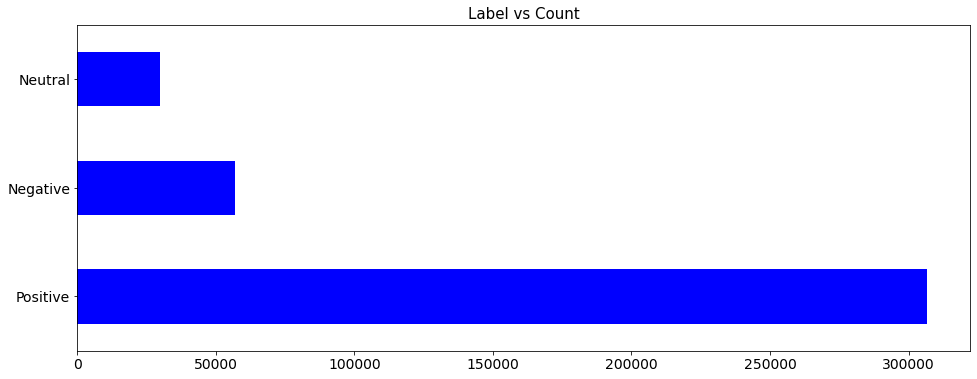

In [10]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

### Down sampling (remove some positive and negative reviews)

In [11]:
neutral = data.loc[data.target=="Neutral"] # 29770 reviews

positive = data.loc[data.target=="Positive"].sample(50000)

negative = data.loc[data.target=="Negative"].sample(50000)

data = pd.concat([positive, negative, neutral])
data.shape

(129770, 11)

### Target distribution (after)

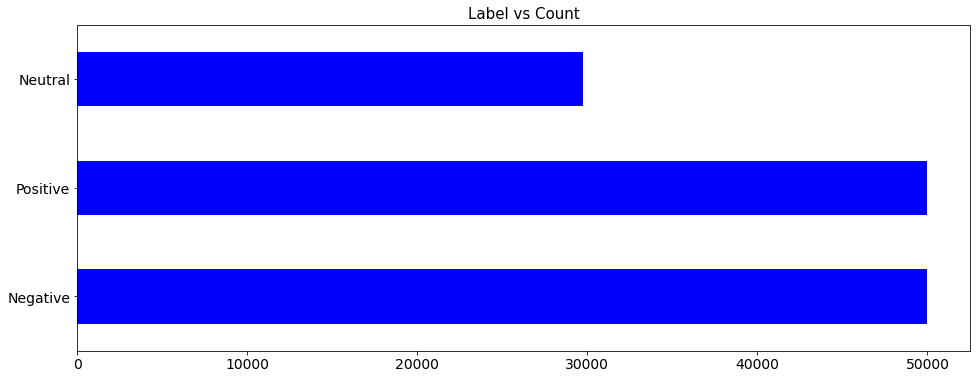

In [12]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

### Stop words

In [13]:
# stopwords
total_stopwords = set(stopwords.words('english'))

# subtract negative stop words like no, not, don't etc.. from total_stopwords
negative_stop_words = set(word for word in total_stopwords 
                          if "n't" in word or 'no' in word)

final_stopwords = total_stopwords - negative_stop_words

# 
final_stopwords.add("one")
print(final_stopwords)

{'during', "she's", 'wasn', 'do', 'myself', 'yourself', 'hasn', 'which', 'any', 'above', 'ourselves', "it's", 'than', 'your', 'she', 'there', 'while', 'between', 'isn', 'these', 'of', 'should', 'himself', 'itself', 'one', 'mightn', 'why', 'further', 'other', 'what', 'y', 'having', 'doing', 'we', 'have', 'who', 'ours', 'for', 'hadn', 'if', 'me', 'was', 'here', 'own', 'our', 'yourselves', 'you', 'both', 'had', 'because', 'mustn', 'as', 'didn', 'so', 'they', 'themselves', 'more', 'hers', 'below', 'don', 'he', 'aren', 'that', 'i', 'her', 'but', 'will', 'him', 'such', 'off', 'on', 'his', 'just', 'into', 'ma', 'wouldn', 'couldn', 'over', 'through', 'only', 'all', 'in', 'from', 'a', 'where', 'theirs', 'when', 'does', 'is', 'my', 'm', 'again', 'its', 'some', 'being', 'before', 'd', 'shouldn', "you're", 'each', "you'd", 'the', 'how', 'same', 'll', 'o', 'ain', 'needn', 'under', 'are', 'them', "that'll", 'down', 'those', 'with', 't', 'an', 'be', 'can', 'by', 'it', 'against', "you'll", 'and', 'doe

### Remove unwanted words from reviews
#### Ex. html tags, punctuation, stop words, etc..

In [14]:
#stemming object
stemmer = PorterStemmer()

# ---------------------------------------------
HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")
# ---------------------------------------------

In [15]:
def preprocessor(review):
    # remove html tags
    review = HTMLTAGS.sub(r'', review)

    # remove puncutuation
    review = review.translate(table)
    
    # remove digits
    review = review.translate(remove_digits)
    
    # lower case all letters
    review = review.lower()
    
    # replace multiple white spaces with single space
    review = MULTIPLE_WHITESPACE.sub(" ", review).strip()
    
    # remove stop words
    review = [word for word in review.split()
              if word not in final_stopwords]
    
    # stemming
    review = ' '.join([stemmer.stem(word) for word in review])
    
    return review

In [16]:
print("Before preprocessing : ")
data.Text.iloc[6]

Before preprocessing : 


'This is the ONLY dog treat that my Lhasa Apso will eat. It makes me happ becuase it has NO added ingredients or preservatives, as well as NO ADDED SALT! This is the ONLY dog treat that my Vet approves of!'

In [17]:
# apply preprocessing function

data.Text = data.Text.apply(preprocessor) 
print("After preprocessing : ")
data.Text.iloc[6]

After preprocessing : 


'dog treat lhasa apso eat make happ becuas no ad ingredi preserv well no ad salt dog treat vet approv'

In [53]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)
    
    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)
    
    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

### Word cloud for Positive reviews

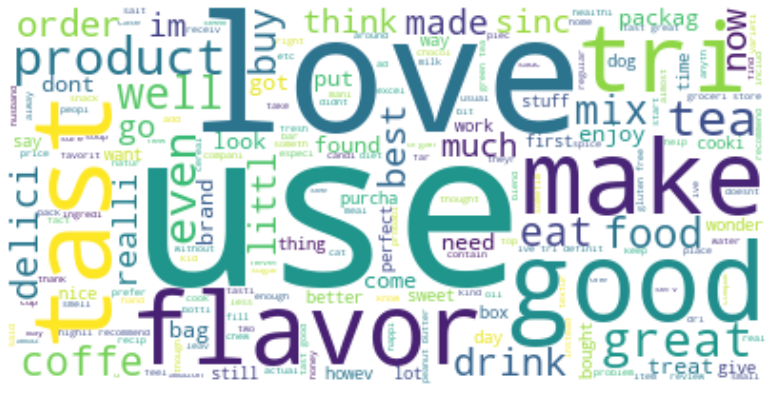

In [54]:
pos = data.loc[data.target=="Positive"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

### Word cloud for Negative reviews

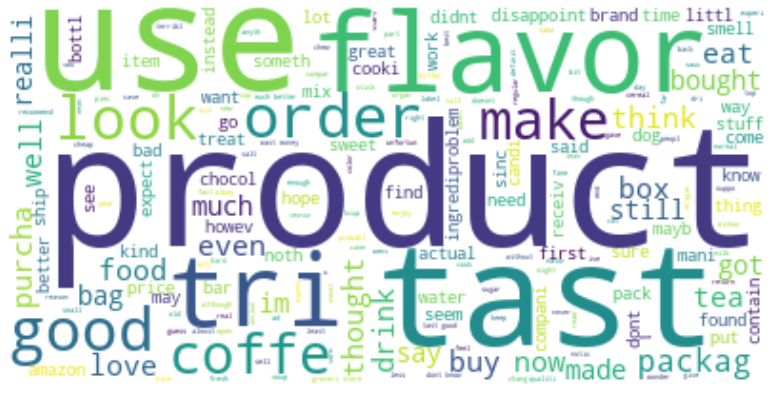

In [55]:
pos = data.loc[data.target=="Negative"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

### Word cloud for Neutral reviews

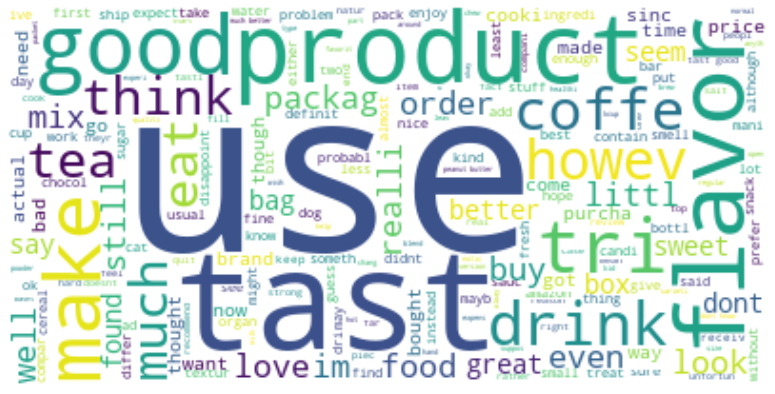

In [56]:
pos = data.loc[data.target=="Neutral"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

In [22]:
X = data.Text
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    
    X, y, test_size=0.20, random_state=1, stratify=y)

In [23]:
X_train.shape, X_test.shape

((103816,), (25954,))

### Bag of Words Vectorizer

In [24]:
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)

# transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

### TF-IDF Vectorizer

In [25]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

###  Label Encoding

In [26]:
labelEncoder = LabelEncoder()

y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()
print(labels) # index-> class

['Negative', 'Neutral', 'Positive']


In [27]:
### 
def train_and_eval(model, trainX, trainY, testX, testY):

    # training
    _ = model.fit(trainX, trainY)

    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n',40*'-')

## Logistic Regression with BoW

In [28]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C: 
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.6999691762348771
Test accuracy score : 0.693611774678277

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.7373140941666024
Test accuracy score : 0.7173846035293211

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.7666929952993758
Test accuracy score : 0.7147645834938737

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.7866899129228635
Test accuracy score : 0.7045927410033136

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.7927872389612391
Test accuracy score : 0.6933805964398552

 ----------------------------------------


## Naive Bayes Classifier with BoW

In [29]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas: 
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.7108056561609001
Test accuracy score : 0.6855975957463204

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.7098038837944055
Test accuracy score : 0.687023194883255

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.7094667488633737
Test accuracy score : 0.6871002542960623

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.7090236572397318
Test accuracy score : 0.6872158434152732

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.7089080681205209
Test accuracy score : 0.687447021653695

 ----------------------------------------


## Logistic Regression with Tf-Idf

In [30]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C: 
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.6436580103259614
Test accuracy score : 0.6436002157663558

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.6780650381444093
Test accuracy score : 0.6745010403020729

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.7310722817292132
Test accuracy score : 0.7167295985204593

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.763697310626493
Test accuracy score : 0.7228558218386376

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.7874027124913309
Test accuracy score : 0.7097942513678046

 ----------------------------------------


## Naive Bayes classifier with Tf-Idf

In [31]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas: 
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.7157856207135702
Test accuracy score : 0.6840949371965785

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.714099946058411
Test accuracy score : 0.6859443631039531

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.7115858827155737
Test accuracy score : 0.6875240810665023

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.7100928565924328
Test accuracy score : 0.6876781998921169

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.7083108576712646
Test accuracy score : 0.6870617245896586

 ----------------------------------------


In [32]:
def plot_cm(y_true, y_pred):
    plt.figure(figsize=(6,6))
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    sns.heatmap(
        cm, annot=True, cmap='Blues', cbar=False, fmt='.2f',
        xticklabels=labels, yticklabels=labels)
    
    return plt.show()

### Best model : Logistic Regression(C=1) with TfIdf data

In [33]:
bmodel = LogisticRegression(C=1, max_iter=500, random_state=1)
bmodel.fit(tfidf_X_train, y_train)

LogisticRegression(C=1, max_iter=500, random_state=1)

In [34]:
# predictions
y_preds_train = bmodel.predict(tfidf_X_train)
y_preds_test = bmodel.predict(tfidf_X_test)

### Accuracy

In [35]:
print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")

Train accuracy score : 0.763697310626493
Test accuracy score : 0.7228558218386376


### Confusion Matrix

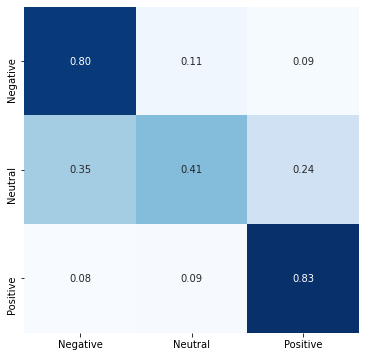

In [36]:
plot_cm(y_test, y_preds_test)

### Observations

#### - Our model is performing better on classifying positive and negative reviews.
#### - Need improvement in classifying the neutral reviews (Any suggestions??)

### Save model and transformer

In [37]:
with open("transformer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)
    
with open("model.pkl", "wb") as f:
    pickle.dump(bmodel, f)

### Prediction on single review

In [38]:
# labels = ['Negative', 'Neutral', 'Positive']
def get_sentiment(review):
    # preprocessing
    x = preprocessor(review)
    #vectorization
    x = tfidf_vectorizer.transform([x])
    #prediction
    y = int(bmodel.predict(x.reshape(1,-1)))
    return labels[y]

In [39]:
# positve review
review = "This chips packet is very tasty. I highly recommend this!"
print(f"This is a {get_sentiment(review)} review!")

This is a Positive review!


In [40]:
# positve review
review = "This product is a waste of money. Don't buy this!!"
print(f"This is a {get_sentiment(review)} review!")

This is a Negative review!
